## Installation needed

In [1]:
# !pip install tensorflow
# !pip install opencv-python
# !pip install keras

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('dark_background')
import seaborn as sns
from tqdm import tqdm

import cv2
import os
import tensorflow as tf
import sklearn as sk

import warnings
warnings.filterwarnings('ignore')

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.4.1


## Import files

In [2]:
main_data = pd.read_csv('data_labels_mainData.csv')
extra_data = pd.read_csv('data_labels_extraData.csv')

In [3]:
main_data

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1
9892,1626,60,1626.png,epithelial,2,1
9893,1627,60,1627.png,epithelial,2,1
9894,1628,60,1628.png,epithelial,2,1


In [4]:
extra_data

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0
...,...,...,...,...
10379,20028,99,20028.png,0
10380,20029,99,20029.png,0
10381,20030,99,20030.png,0
10382,20031,99,20031.png,0


## Image inspect

In [24]:
# Prepare some image of each class
cell0 = main_data['ImageName'].loc[main_data['cellType'] == 0][:4].tolist()
cell1 = main_data['ImageName'].loc[main_data['cellType'] == 1][:4].tolist()
cell2 = main_data['ImageName'].loc[main_data['cellType'] == 2][:4].tolist()
cell3 = main_data['ImageName'].loc[main_data['cellType'] == 3][:4].tolist()

print(cell0)
print(cell1)
print(cell2)
print(cell3)

['22405.png', '22406.png', '22407.png', '22408.png']
['22417.png', '22418.png', '22419.png', '22420.png']
['276.png', '277.png', '278.png', '279.png']
['22423.png', '22424.png', '19061.png', '19062.png']


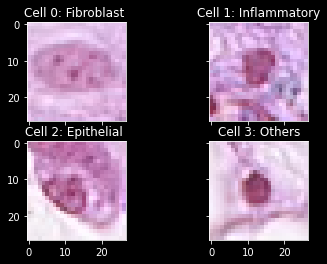

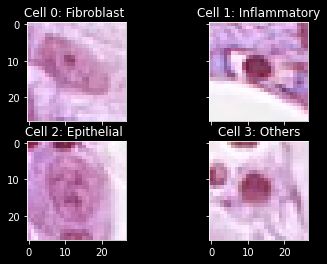

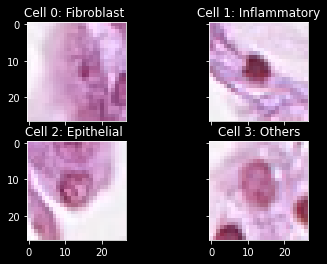

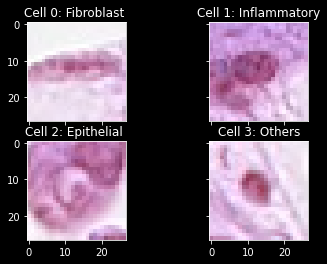

In [37]:
# CHANGE THE DIRECTORY IN YOUR LOCAL MACHINE
directory = r"C:\Users\luong\Documents\GitHub\ML\Asm\ASM2\patch_images"

for i in range (4):
    cell_0 = cv2.imread(os.path.join(directory, cell0[i]))
    cell_1 = cv2.imread(os.path.join(directory, cell1[i]))
    cell_2 = cv2.imread(os.path.join(directory, cell2[i]))
    cell_3 = cv2.imread(os.path.join(directory, cell3[i]))

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    
    ax1.title.set_text("Cell 0: Fibroblast ")
    ax1.imshow(cell_0)
    
    ax2.title.set_text("Cell 1: Inflammatory")
    ax2.imshow(cell_1)
    
    ax3.title.set_text("Cell 2: Epithelial ")
    ax3.imshow(cell_2)
    
    ax4.title.set_text("Cell 3: Others")
    ax4.imshow(cell_3)

    for ax in fig.get_axes():
        ax.label_outer()

## Prepare data

In [38]:
from sklearn.model_selection import train_test_split
X = main_data['ImageName']
y = main_data['cellType']

train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.33)
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.2)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_X.shape[0], val_X.shape[0], test_X.shape[0]))

Train data : 5304, Val Data: 1326, Test Data: 3266


In [39]:
train_Y = train_Y.ravel()
val_Y = val_Y.ravel()
test_Y = test_Y.ravel()

## Transfer to image array

In [40]:
def create_train_data(directory, img_list):
    IMAGE_SIZE = 27
    train_data = []
    for img in tqdm(img_list, desc='Extracting Image Progress'):
        path = os.path.join(directory, img)
        img = cv2.resize(cv2.imread(path), (IMAGE_SIZE,IMAGE_SIZE))
        train_data.append(np.array(img))
    print("Successfully import images!")
    # Convert to np.array and normalize pixel values to be between 0 and 1 
    return np.array(train_data).astype('float32') / 255.0 

In [42]:
# CHANGE THE PATH TO IMAGE FOLDER IN YOUR LOCAL DEVICE!
path = r"C:\Users\luong\Documents\GitHub\ML\Asm\ASM2\patch_images"

train_X_img = create_train_data(path, train_X.tolist())
val_X_img = create_train_data(path, val_X.tolist())
test_X_img = create_train_data(path, test_X.tolist())

Extracting Image Progress:  46%|██████████████████████▉                           | 608/1326 [00:00<00:00, 6073.16it/s]

Successfully import images!


Extracting Image Progress:  20%|██████████                                        | 655/3266 [00:00<00:00, 6527.19it/s]

Successfully import images!


Extracting Image Progress: 100%|█████████████████████████████████████████████████| 3266/3266 [00:00<00:00, 7754.45it/s]

Successfully import images!


In [46]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(featurewise_center=True,
                                   featurewise_std_normalization=True, 
                                   rotation_range=20, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest', 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2)

In [47]:
train_it = train_datagen.flow(train_X_img, train_Y)

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D , Flatten, BatchNormalization, Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27,27, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 27, 27, 32)        896       
_________________________________________________________________
batch_normalization_11 (Batc (None, 27, 27, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 25, 25, 32)        9248      
_________________________________________________________________
batch_normalization_12 (Batc (None, 25, 25, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 12, 12, 64)       

In [61]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=0.000001)
model.compile(optimizer = opt , 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 256)         2

In [63]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("RCC", 
                             monitor='val_acc',
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', period=1)

early = EarlyStopping(monitor='accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

hist = model.fit(train_it, 
                 validation_data = (test_X_img, test_Y), 
                 batch_size = 32, 
                 epochs = 100, 
                 verbose=1,
                 callbacks=[early,checkpoint])

Epoch 1/100
166/166 [==============================] - 24s 146ms/step - loss: 1.4009 - accuracy: 0.4683 - val_loss: 1.2118 - val_accuracy: 0.5282
Epoch 2/100
166/166 [==============================] - 23s 141ms/step - loss: 1.3752 - accuracy: 0.4721 - val_loss: 1.2002 - val_accuracy: 0.5355
Epoch 3/100
166/166 [==============================] - 23s 136ms/step - loss: 1.3497 - accuracy: 0.4804 - val_loss: 1.1934 - val_accuracy: 0.5389
Epoch 4/100
166/166 [==============================] - 22s 135ms/step - loss: 1.3301 - accuracy: 0.4864 - val_loss: 1.1793 - val_accuracy: 0.5459
Epoch 5/100
166/166 [==============================] - 26s 156ms/step - loss: 1.3116 - accuracy: 0.4926 - val_loss: 1.1606 - val_accuracy: 0.5557
Epoch 6/100
166/166 [==============================] - 24s 145ms/step - loss: 1.3134 - accuracy: 0.5068 - val_loss: 1.1515 - val_accuracy: 0.5585
Epoch 7/100
166/166 [==============================] - 23s 137ms/step - loss: 1.3136 - accuracy: 0.4960 - val_loss: 1.1323 -

Epoch 37/100
166/166 [==============================] - 20s 123ms/step - loss: 1.1067 - accuracy: 0.5880 - val_loss: 0.9470 - val_accuracy: 0.6433
Epoch 38/100
166/166 [==============================] - 19s 116ms/step - loss: 1.0933 - accuracy: 0.5952 - val_loss: 0.9428 - val_accuracy: 0.6421
Epoch 39/100
166/166 [==============================] - 18s 110ms/step - loss: 1.0950 - accuracy: 0.5965 - val_loss: 0.9476 - val_accuracy: 0.6433
Epoch 40/100
166/166 [==============================] - 19s 117ms/step - loss: 1.0941 - accuracy: 0.5924 - val_loss: 0.9369 - val_accuracy: 0.6464
Epoch 41/100
166/166 [==============================] - 20s 121ms/step - loss: 1.0626 - accuracy: 0.6018 - val_loss: 0.9355 - val_accuracy: 0.6482
Epoch 42/100
166/166 [==============================] - 20s 121ms/step - loss: 1.0831 - accuracy: 0.5975 - val_loss: 0.9350 - val_accuracy: 0.6457
Epoch 43/100
166/166 [==============================] - 19s 115ms/step - loss: 1.0819 - accuracy: 0.6001 - val_loss: 0

166/166 [==============================] - 18s 109ms/step - loss: 0.9802 - accuracy: 0.6414 - val_loss: 0.8713 - val_accuracy: 0.6748
Epoch 74/100
166/166 [==============================] - 18s 107ms/step - loss: 1.0040 - accuracy: 0.6276 - val_loss: 0.8692 - val_accuracy: 0.6736
Epoch 75/100
166/166 [==============================] - 19s 112ms/step - loss: 0.9898 - accuracy: 0.6267 - val_loss: 0.8669 - val_accuracy: 0.6770
Epoch 76/100
166/166 [==============================] - 18s 109ms/step - loss: 1.0206 - accuracy: 0.6333 - val_loss: 0.8676 - val_accuracy: 0.6782
Epoch 77/100
166/166 [==============================] - 18s 109ms/step - loss: 1.0235 - accuracy: 0.6212 - val_loss: 0.8601 - val_accuracy: 0.6776
Epoch 78/100
166/166 [==============================] - 18s 110ms/step - loss: 1.0229 - accuracy: 0.6307 - val_loss: 0.8627 - val_accuracy: 0.6764
Epoch 79/100
166/166 [==============================] - 18s 110ms/step - loss: 1.0193 - accuracy: 0.6152 - val_loss: 0.8634 - val_a

In [64]:
model.save('Baseline RCCNet')

INFO:tensorflow:Assets written to: Baseline RCCNet\assets


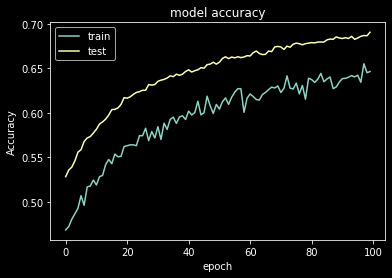

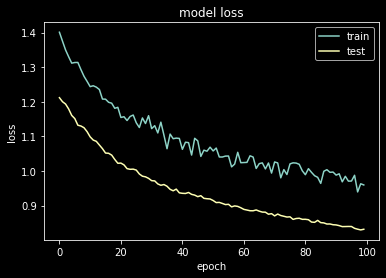

In [81]:
# Summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [79]:
from sklearn.metrics import classification_report
pred = model.predict_classes(test_X_img)
pred.reshape(1,-1)[0]
print(classification_report(test_Y, pred))

              precision    recall  f1-score   support

           0       0.66      0.50      0.57       606
           1       0.63      0.71      0.66       840
           2       0.84      0.85      0.84      1334
           3       0.44      0.45      0.45       486

    accuracy                           0.69      3266
   macro avg       0.64      0.63      0.63      3266
weighted avg       0.69      0.69      0.69      3266

